数据说明：某城市各企业用电数据，从2015-1-1至2016-8-31，任务是预测未来一个月（即2016-9月）的用电情况

方法：特征工程+lightGBM

lightGBM 安装：pip3 install lightgbm

lightGBM官方文档：https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

lightGBM有2种Python API：1种是 sklearn 风格的Python API，还有一套自己原生的Python API

下面是使用 sklearn 风格 Python API的示例

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os
print(os.getcwd())
cwd = '/home/xijian/pycharm_projects/Magic-NLPer/MachineLearning/AdaBoost/'
data_dir = cwd + 'data/'

/home/xijian


In [4]:
# 加载数据
df = pd.read_csv(data_dir + 'tianchi_power_AI.csv')
# 格式转换  将时间字符串转换为pandas认识的时间字段/列
df['record_date'] = pd.to_datetime(df['record_date'])
df.head()

,user_id,record_date,power_consumption
0,1,2015-01-01,1135.0
1,1,2015-01-02,570.0
2,1,2015-01-03,3418.0
3,1,2015-01-04,3968.0
4,1,2015-01-05,3986.0


In [6]:
# 按每年每个月分组求和
base_df = df[['record_date', 'power_consumption']].groupby(by='record_date').agg('sum')
base_df = base_df.reset_index()
print(base_df['record_date'].min())
print(base_df['record_date'].max())
base_df.head()

2015-01-01 00:00:00
2016-08-31 00:00:00


,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


### 特征工程

直接对每天的总量进行回归拟合，先提取用以回归的特征

In [7]:
df_test = base_df[ (base_df['record_date']>='2016-08-01') &
                   (base_df['record_date']<='2016-08-30')]
# Timedelta： 时间差类型
df_test['record_date'] = df_test['record_date']+pd.Timedelta('31 days') # 8月日期转9月日期
df_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,record_date,power_consumption
578,2016-09-01,4627029.0
579,2016-09-02,4618467.0
580,2016-09-03,4490739.0
581,2016-09-04,4367727.0
582,2016-09-05,4253298.0


In [8]:
base_df = pd.concat([base_df, df_test]).sort_values(['record_date']) # 包含了2016-9月预测月
base_df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


In [9]:
# 提取年、月、日、星期几、一月中的第几天、第几季度等特征
base_df['dayofweek'] = base_df['record_date'].apply(lambda x: x.dayofweek)
base_df['dayofyear'] = base_df['record_date'].apply(lambda x: x.dayofyear)
base_df['day'] = base_df['record_date'].apply(lambda x: x.day)
base_df['month'] = base_df['record_date'].apply(lambda x: x.month)
base_df['year'] = base_df['record_date'].apply(lambda x: x.year)
base_df.head()

,record_date,power_consumption,dayofweek,dayofyear,day,month,year
0,2015-01-01,2900575.0,3,1,1,1,2015
1,2015-01-02,3158211.0,4,2,2,1,2015
2,2015-01-03,3596487.0,5,3,3,1,2015
3,2015-01-04,3939672.0,6,4,4,1,2015
4,2015-01-05,4101790.0,0,5,5,1,2015


In [10]:
# 映射到第几季度
def map_season(month):
    month_dict = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4}
    return month_dict[month]

base_df['season'] = base_df['month'].apply(lambda x: map_season(x))
base_df.head()

,record_date,power_consumption,dayofweek,dayofyear,day,month,year,season
0,2015-01-01,2900575.0,3,1,1,1,2015,1
1,2015-01-02,3158211.0,4,2,2,1,2015,1
2,2015-01-03,3596487.0,5,3,3,1,2015,1
3,2015-01-04,3939672.0,6,4,4,1,2015,1
4,2015-01-05,4101790.0,0,5,5,1,2015,1


In [11]:
# 按每年每月分组 计算统计信息：均值、标准差
base_df_stats = base_df[ ['power_consumption', 'year', 'month'] ].groupby(by=['year', 'month']).agg(['mean', 'std'])
base_df_stats.columns = base_df_stats.columns.droplevel(0)
print(base_df_stats.head())
base_df_stats = base_df_stats.reset_index()
base_df_stats.head()

                    mean            std
year month                             
2015 1      3.961383e+06  303629.486622
     2      2.795163e+06  769697.864999
     3      3.478852e+06  564753.747993
     4      3.768333e+06  190787.832757
     5      3.755262e+06  269088.249265


,year,month,mean,std
0,2015,1,3.961383e+06,303629.486622
1,2015,2,2.795163e+06,769697.864999
2,2015,3,3.478852e+06,564753.747993
3,2015,4,3.768333e+06,190787.832757
4,2015,5,3.755262e+06,269088.249265


In [16]:
base_df_stats['1_m_mean'] = base_df_stats['mean'].shift(1) # 向下移动1
base_df_stats['2_m_mean'] = base_df_stats['mean'].shift(2) # 向下移动2
base_df_stats['1_m_std'] = base_df_stats['std'].shift(1) # 向下移动1
base_df_stats['2_m_std'] = base_df_stats['std'].shift(2) # 向下移动2
base_df_stats.head()

,year,month,mean,std,1_m_mean,2_m_mean,1_m_std,2_m_std
0,2015,1,3.961383e+06,303629.486622,NaN,NaN,NaN,NaN
1,2015,2,2.795163e+06,769697.864999,3.961383e+06,NaN,303629.486622,NaN
2,2015,3,3.478852e+06,564753.747993,2.795163e+06,3.961383e+06,769697.864999,303629.486622
3,2015,4,3.768333e+06,190787.832757,3.478852e+06,2.795163e+06,564753.747993,769697.864999
4,2015,5,3.755262e+06,269088.249265,3.768333e+06,3.478852e+06,190787.832757,564753.747993


In [17]:
data_df = pd.merge(base_df, base_df_stats[ ['year', 'month', '1_m_mean', '2_m_mean', '1_m_std', '2_m_std'] ],
                   how='inner', on=['year', 'month'])
print(data_df.head())
data_df = data_df[~pd.isnull(data_df['2_m_mean'])] # 去掉Nan数据
data_df.head()

  record_date  power_consumption  dayofweek  dayofyear  day  month  year  \
0  2015-01-01          2900575.0          3          1    1      1  2015   
1  2015-01-02          3158211.0          4          2    2      1  2015   
2  2015-01-03          3596487.0          5          3    3      1  2015   
3  2015-01-04          3939672.0          6          4    4      1  2015   
4  2015-01-05          4101790.0          0          5    5      1  2015   

   season  1_m_mean  2_m_mean  1_m_std  2_m_std  
0       1       NaN       NaN      NaN      NaN  
1       1       NaN       NaN      NaN      NaN  
2       1       NaN       NaN      NaN      NaN  
3       1       NaN       NaN      NaN      NaN  
4       1       NaN       NaN      NaN      NaN  


,record_date,power_consumption,dayofweek,dayofyear,day,month,year,season,1_m_mean,2_m_mean,1_m_std,2_m_std
59,2015-03-01,2900464.0,6,60,1,3,2015,1,2.795163e+06,3.961383e+06,769697.864999,303629.486622
60,2015-03-02,3334082.0,0,61,2,3,2015,1,2.795163e+06,3.961383e+06,769697.864999,303629.486622
61,2015-03-03,3492606.0,1,62,3,3,2015,1,2.795163e+06,3.961383e+06,769697.864999,303629.486622
62,2015-03-04,3597890.0,2,63,4,3,2015,1,2.795163e+06,3.961383e+06,769697.864999,303629.486622
63,2015-03-05,1798044.0,3,64,5,3,2015,1,2.795163e+06,3.961383e+06,769697.864999,303629.486622


In [18]:
data_df.tail()

,record_date,power_consumption,dayofweek,dayofyear,day,month,year,season,1_m_mean,2_m_mean,1_m_std,2_m_std
634,2016-09-26,4018774.0,0,270,26,9,2016,3,4.072800e+06,4.458408e+06,337880.572544,276925.542329
635,2016-09-27,3610828.0,1,271,27,9,2016,3,4.072800e+06,4.458408e+06,337880.572544,276925.542329
636,2016-09-28,3446470.0,2,272,28,9,2016,3,4.072800e+06,4.458408e+06,337880.572544,276925.542329
637,2016-09-29,3681879.0,3,273,29,9,2016,3,4.072800e+06,4.458408e+06,337880.572544,276925.542329
638,2016-09-30,3607667.0,4,274,30,9,2016,3,4.072800e+06,4.458408e+06,337880.572544,276925.542329


### lightGBM

In [19]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

train_data = data_df[data_df['record_date']<'2016-09-01']\
    [['dayofweek','dayofyear','day','month','year','season','1_m_mean','2_m_mean','1_m_std','2_m_std']]
test_data = data_df[data_df['record_date']>='2016-09-01']\
    [['dayofweek','dayofyear','day','month','year','season','1_m_mean','2_m_mean','1_m_std','2_m_std']]
train_target = data_df[data_df['record_date']<'2016-09-01'][ ['power_consumption'] ]

In [20]:

train_lgb = train_data.copy()
# 日期/时间格式转换为str类型
train_lgb[ ['dayofweek','dayofyear','day','month','year','season'] ] = \
    train_lgb[ ['dayofweek','dayofyear','day','month','year','season'] ].astype(str)
test_lgb = test_data.copy()
test_lgb[ ['dayofweek','dayofyear','day','month','year','season'] ] = \
    test_lgb[ ['dayofweek','dayofyear','day','month','year','season'] ].astype(str)

In [21]:
X_lgb = train_lgb.values
y_lgb = train_target.values.reshape(X_lgb.shape[0],)
print(X_lgb.shape, y_lgb.shape, type(X_lgb))
print(X_lgb[0, :])

(550, 10) (550,) <class 'numpy.ndarray'>
['6' '60' '1' '3' '2015' '1' 2795163.0535714286 3961383.0967741935
 769697.8649992085 303629.48662213905]


In [22]:

# 模型参数
estimator = lgb.LGBMRegressor(colsample_bytree=0.8, # 建每棵树时使用的属性列的比例（属性采样比例）
                             subsample=0.9, # 使用训练样本的比例（样本采样比例）
                             subsample_freq=5) # 采样频率
param_grid = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'n_estimators': [100, 200, 400, 800, 1000, 1200, 1500, 2000], # 要学习的boosted trees 个数
    'num_leaves': [128, 1024, 4096], # base learner的最大叶子节点数
}

# 训练参数
fit_params = {'categorical_feature': [0,1,2,3,4,5]} # 哪些列是类别型特征，list of int则表示索引

In [23]:

import warnings
warnings.filterwarnings("ignore") # 不打印warning信息

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_lgb, y_lgb, **fit_params)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.02, 'n_estimators': 1200, 'num_leaves': 128}


In [24]:
# 使用最佳参数，重新训练模型
lgbm = lgb.LGBMRegressor(colsample_bytree=0.8, # 建每棵树时使用的属性列的比例（属性采样比例）
                         subsample=0.9, # 使用训练样本的比例（样本采样比例）
                         subsample_freq=5, # 采样频率
                         learning_rate=0.02,
                         n_estimators=1200,
                         num_leaves=128,
                         objective='regression_l1'
                         )
lgbm.fit(X_lgb, y_lgb)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.02, n_estimators=1200,
              num_leaves=128, objective='regression_l1', subsample=0.9,
              subsample_freq=5)

In [29]:
X_pred = test_lgb.values
print(X_pred.shape)
y_pred = lgbm.predict(X_pred)
print(y_pred.shape)

(30, 10)
(30,)


Plot feature importances...


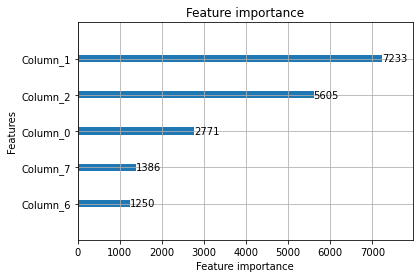

In [32]:
print('Plot feature importances...')
ax = lgb.plot_importance(lgbm, max_num_features=5) # max_num_features 显示最重要的5个特征
plt.show()